***21022008_NguyenHuuTho***

**import thư viện**

In [1]:
import pandas as pd 
import numpy as np 
import math

**load dữ liệu**

In [3]:
dfdata = pd.read_csv('/content/drive/MyDrive/TH1391_NLMH/Week8_Thuchanh2/Dataset-football-train.txt',sep='\t')
dfdata.head()

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,1,9/5/15,Texas,Home,Out,NBC,Win
1,2,9/12/15,Virginia,Away,Out,ABC,Win
2,3,9/19/15,Georgia Tech,Home,In,NBC,Win
3,4,9/26/15,UMass,Home,Out,NBC,Win
4,5,10/3/15,Clemson,Away,In,ABC,Lose


**Xác định các thuộc tính dữ liệu**

In [26]:
data_train=dfdata[['Is_Home_or_Away','Is_Opponent_in_AP25_Preseason','Media','Label']]
data_train.head()

,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,1,1,4,Win
1,0,1,0,Win
2,1,0,4,Win
3,1,1,4,Win
4,0,0,0,Lose


In [27]:
# Tạo thuộc tính
attribute = list(data_train.columns) # Dùng header để lấy thuộc tính
attribute

['Is_Home_or_Away', 'Is_Opponent_in_AP25_Preseason', 'Media', 'Label']

**Xây dựng class Tree**

In [23]:
class Tree:
  def __init__(self,observationIDs,features,currLvl=0,subTree={},bestFeature=None,majorityLabel=None,parentMajorityLabel=None):
    self.observationIDs = observationIDs
    self.features = features
    self.currLvl = currLvl
    self.subTree = subTree
    self.bestFeature = bestFeature
    self.majorityLabel = majorityLabel
    self.parentMajorityLabel = parentMajorityLabel
    self.setBestFeatureID(bestFeature)
    
  def setBestFeatureID(self, feature):
    idx = None
    if feature == 'Is_Home_or_Away':
      idx = 0
    elif feature == 'Is_Opponent_in_AP25_Preseason':
      idx = 1
    else:
      idx = 2
    self.bestFeatureID = int(idx)

**Xây dựng hàm dự đoán**

In [24]:
def predict(tree, obs):
	if tree.bestFeature == None:
		return tree.majorityLabel
	featVal = obs[tree.bestFeatureID]
	if not featVal in tree.subTree: # val with no subtree
		return tree.majorityLabel
	else: # recurse on subtree
		return predict(tree.subTree[featVal],obs)

**Hàm hiển thị cây**

In [25]:
def displayDecisionTree(tree):
	print('\t'*tree.currLvl + '(lvl {}) {}'.format(tree.currLvl,tree.majorityLabel))
	if tree.bestFeature == None:
		return

	print('\t'*tree.currLvl + '{}'.format(tree.bestFeature) + ': ')
	for [val,subTree] in sorted(tree.subTree.items()):
		print('\t'*(tree.currLvl+1) + 'choice: {}'.format(val))
		displayDecisionTree(subTree)

**Hàm tính Entropy**

In [8]:
def Entropy(ns):
	entropy = 0.0
	total = sum(ns)
	for x in ns:
		entropy += -1.0*x/total*math.log(1.0*x/total,2)
	return entropy

# **THUẬT TOÁN ID3**

**Hàm tính Information Gain**

In [9]:
def IG(observationIDs, feature,dfdata):
	# get smaller dataframe
	df = dfdata.loc[list(observationIDs)]
	# populate counts for Wins/Losses for each category of the feature
	labelCountDict = {}
	valueLabelCountDict = {}
	for index, row in df.iterrows():
		label = row['Label']
		if not label in labelCountDict:
			labelCountDict[label] = 0 # this specific label was not found so insert 0 count
		labelCountDict[label] += 1
		featureValue = row[feature]
		if not featureValue in valueLabelCountDict:
			valueLabelCountDict[featureValue] = {} # this specific feature value not found so insert empty dict
		if not label in valueLabelCountDict[featureValue]:
			valueLabelCountDict[featureValue][label] = 0 # this specific label was not found for this feature value so insert 0 count
		valueLabelCountDict[featureValue][label] += 1

	ns = []
	for [label,count] in labelCountDict.items():
		ns.append(count)

	H_Y = Entropy(ns)

	H_Y_X = 0.0
	for [featureValue, labelCountDict] in valueLabelCountDict.items():
		nsHYX = []
		for [label,count] in labelCountDict.items():
			nsHYX.append(count)
		H_Y_X += 1.0*sum(nsHYX)/len(df)*Entropy(nsHYX)
	return H_Y - H_Y_X

# **THUẬT TOÁN C4.5**

**Hàm tính Gain Ratio**

In [10]:
def GR(observationIDs, feature,dfdata):
	ig = IG(observationIDs,feature)
	if ig == 0:
		return 0
	df = dfdata.loc[list(observationIDs)]
	valueLabelDict = {}
	for index, row in df.iterrows():
		label = row['Label']
		featureValue = row[feature]
		if featureValue not in valueLabelDict:
			valueLabelDict[featureValue] = 0
		valueLabelDict[featureValue] += 1
	ns = []
	for [val,count] in valueLabelDict.items():
		ns.append(count)
	ent = Entropy(ns)
	return float(ig)/ent

**Hàm xây dựng Cây quyết định**

In [11]:
def fillDecisionTree(tree,decisionTreeAlgo,dfdata):
	# find the majorityLabel
	df = dfdata.loc[list(tree.observationIDs)] # smaller df
	counts = df['Label'].value_counts()
	majorityLabel = df['Label'].value_counts().idxmax()
	if len(counts) > 1:
		if counts['Win'] == counts['Lose']:
			majorityLabel = tree.parentMajorityLabel
	tree.majorityLabel = majorityLabel

	# exit if only one label
	if len(counts) == 1:
		return
	# exit if no features left
	if len(tree.features) == 0: 
		return

	# find best feature
	featureValueDict = {}
	for feature in tree.features: 
		if decisionTreeAlgo == 'ID3':
			metricScore = IG(tree.observationIDs,feature,dfdata)
		if decisionTreeAlgo == 'C45':
			metricScore = GR(tree.observationIDs,feature,dfdata)
		featureValueDict[feature] = metricScore
	bestFeature, bestFeatureValue = sorted(featureValueDict.items(),reverse=True)[0]
	# exit if IG or GR is 0
	if bestFeatureValue == 0.0:
		return
	tree.bestFeature = bestFeature

	# find subset of features
	subFeatures = set()
	for feature in tree.features:
		if feature == bestFeature: # skip the current best feature
			continue
		subFeatures.add(feature)
	
	# find best feature id
	bestFeatureIdx = 0
	if bestFeature == 'Is_Home_or_Away':
		bestFeatureIdx = 0
	elif bestFeature == 'Is_Opponent_in_AP25_Preseason':
		bestFeatureIdx = 1
	else:
		bestFeatureIdx = 2
	
	# find subset of observations
	subObservationsDict = {}
	for obs in tree.observationIDs:
		val = dfdata.values[obs][bestFeatureIdx]
		if not val in subObservationsDict:
			subObservationsDict[val] = set()
		subObservationsDict[val].add(obs)

	for [val,obs] in subObservationsDict.items():

		tree.subTree[val] = Tree(obs, subFeatures, tree.currLvl + 1,{},None,None,majorityLabel)
		
		fillDecisionTree(tree.subTree[val],decisionTreeAlgo,dfdata)

In [28]:
initialObservationIDs = set(range(len(data_train)))
initialFeatures = set(data_train.columns.values[:-1])

**Lựa chọn thuật toán**

In [29]:
algoChoice = str(input(("Which decision tree algorithm would you like to use ('ID3' or 'C45)?")))
if algoChoice not in {'ID3','C45'}:
	print("Invalid algorithm choice. You must choose 'ID3' or 'C45'")
	exit()

print("choice: {}".format(algoChoice))

Which decision tree algorithm would you like to use ('ID3' or 'C45)?ID3
choice: ID3


**Hiển thị cây**

In [14]:
MyTree = Tree(initialObservationIDs,initialFeatures)
fillDecisionTree(MyTree,algoChoice,data_train)

print('My Decision Tree:')
displayDecisionTree(MyTree)

My Decision Tree:
(lvl 0) Win
Media: 
	choice: ABC
	(lvl 1) Lose
	Is_Opponent_in_AP25_Preseason: 
		choice: In
		(lvl 2) Lose
		choice: Out
		(lvl 2) Win
	choice: CBS
	(lvl 1) Lose
	choice: ESPN
	(lvl 1) Win
	choice: FOX
	(lvl 1) Lose
	choice: NBC
	(lvl 1) Win
	Is_Opponent_in_AP25_Preseason: 
		choice: In
		(lvl 2) Win
		choice: Out
		(lvl 2) Win
		Is_Home_or_Away: 
			choice: Away
			(lvl 3) Win
			choice: Home
			(lvl 3) Win


# **Trực quan hóa cây quyết định**

In [15]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import pandas as pd

**Chuẩn hóa dữ liệu**

In [33]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data_train['Is_Home_or_Away']=le.fit_transform(data_train['Is_Home_or_Away'])
data_train['Is_Opponent_in_AP25_Preseason']=le.fit_transform(data_train['Is_Opponent_in_AP25_Preseason'])
data_train['Media']=le.fit_transform(dfdata['Media'])

**Xác định đặc trưng x và các giá trị mục tiêu y**

In [35]:
# Define features x and target y
x = data_train[['Is_Home_or_Away', 'Is_Opponent_in_AP25_Preseason', 'Media']]
y = data_train['Label']

In [36]:
dt = DecisionTreeClassifier()
dt.fit(x, y)

DecisionTreeClassifier()

**Vẽ cây dựa trên graphviz**

In [40]:
feature_names = data_train[['Is_Home_or_Away', 'Is_Opponent_in_AP25_Preseason', 'Media']].columns.tolist()
class_names = ['Win', 'Lose']

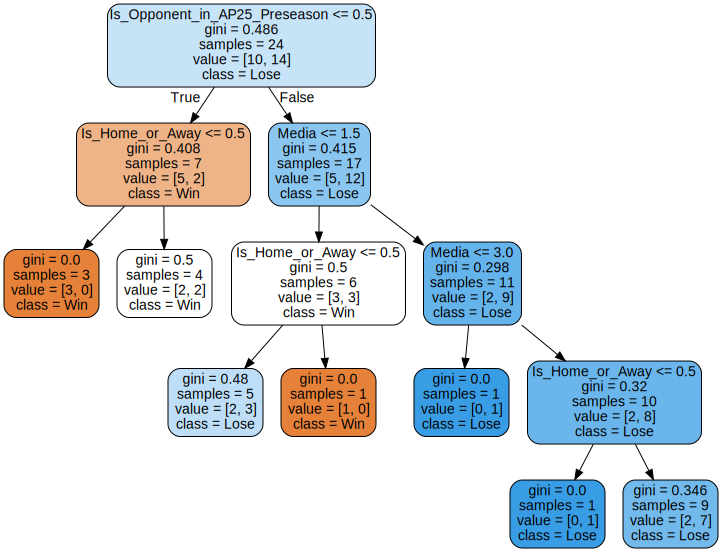

In [41]:
import graphviz
dot_data = tree.export_graphviz(dt,feature_names=feature_names,  
                                class_names=class_names,
                                rounded=True,filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [42]:
dftest = pd.read_csv('/content/drive/MyDrive/TH1391_NLMH/Week8_Thuchanh2/Dataset-football-test-root.txt', sep='\t')
dftest.head(5)

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,25,9/2/17,Temple,Home,Out,NBC
1,26,9/9/17,Georgia,Home,In,NBC
2,27,9/16/17,BostonCollege,Away,Out,ESPN
3,28,9/23/17,MichiganState,Away,Out,FOX
4,29,9/30/17,MiamiOhio,Home,Out,NBC


In [43]:
data_test = dftest.iloc[:, 3:]
data_test.head(5)

,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,Home,Out,NBC
1,Home,In,NBC
2,Away,Out,ESPN
3,Away,Out,FOX
4,Home,Out,NBC


In [44]:
# Use the ID3 decision tree to predict labels for test data
for index, row in data_test.iterrows():
    obs_row = [row[0], row[1], row[2]]
    pred = predict(MyTree, obs_row)
    print(f'Prediction for {obs_row}: {pred}')

Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Home', 'In', 'NBC']: Win
Prediction for ['Away', 'Out', 'ESPN']: Win
Prediction for ['Away', 'Out', 'FOX']: Lose
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Away', 'Out', 'ABC']: Lose
Prediction for ['Home', 'In', 'NBC']: Win
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Away', 'In', 'ABC']: Lose
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Away', 'In', 'ABC']: Lose
